In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, SimpleRNN, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

2024-07-18 10:36:59.798619: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 10:36:59.913126: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 10:37:02.076716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Make data

In [2]:
series = np.sin(0.1 * np.arange(1000)) + np.random.randn(1000) * 0.1

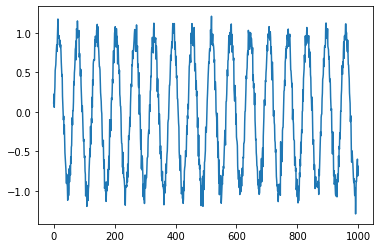

In [3]:
plt.plot(series)
plt.show()

## Build dataset

In [4]:
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)

In [5]:
X.shape, Y.shape

((990, 10, 1), (990,))

## Try autoregressive RNN model

In [6]:
i = Input(shape=(T, 1))
x = SimpleRNN(units=15, activation='relu')(i)
x = Dense(1)(x)

2024-07-18 10:37:07.068578: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
model = Model(i, x)

In [8]:
# compile model
model.compile(loss='mse',
             optimizer=Adam(learning_rate=0.001))

In [9]:
# train the model 
r = model.fit(X[:-N//2], Y[:-N//2],
             epochs=80,
             validation_data=(X[-N//2:], Y[-N//2:]))


Epoch 1/80
16/16 [==============================] - 3s 48ms/step - loss: 0.5750 - val_loss: 0.4000
Epoch 2/80
16/16 [==============================] - 0s 16ms/step - loss: 0.3366 - val_loss: 0.2800
Epoch 3/80
16/16 [==============================] - 0s 17ms/step - loss: 0.2450 - val_loss: 0.2155
Epoch 4/80
16/16 [==============================] - 0s 18ms/step - loss: 0.1899 - val_loss: 0.1656
Epoch 5/80
16/16 [==============================] - 0s 17ms/step - loss: 0.1398 - val_loss: 0.1095
Epoch 6/80
16/16 [==============================] - 0s 17ms/step - loss: 0.0828 - val_loss: 0.0557
Epoch 7/80
16/16 [==============================] - 0s 17ms/step - loss: 0.0424 - val_loss: 0.0344
Epoch 8/80
16/16 [==============================] - 0s 18ms/step - loss: 0.0318 - val_loss: 0.0269
Epoch 9/80
16/16 [==============================] - 0s 16ms/step - loss: 0.0258 - val_loss: 0.0232
Epoch 10/80
16/16 [==============================] - 0s 18ms/step - loss: 0.0218 - val_loss: 0.0194
Epoch 11/

## Plot loss per iteration

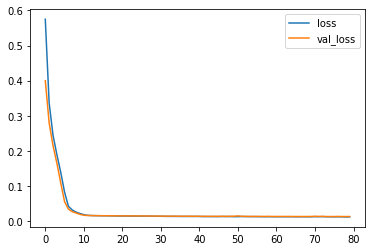

In [10]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

## Wrong forecast using true targets

In [11]:
validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
    p = model.predict(X[i].reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
    i += 1
  
    # update the predictions list
    validation_predictions.append(p)

1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


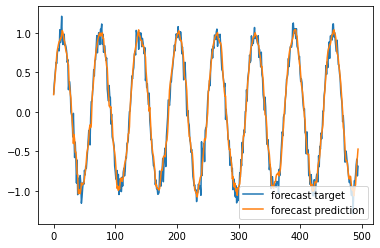

In [12]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

## Forecast future values (use only self-predictions for making future predictions)

In [13]:
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2]    # 1D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1, 1))[0, 0]    # 1x1 array -> scalar
    
    # update the predictions list
    validation_predictions.append(p)
    
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 36ms/step


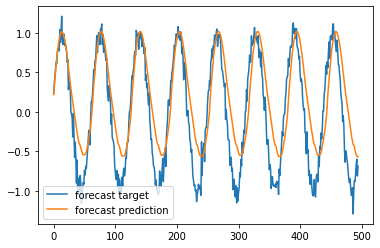

In [14]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 15)                255       
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 271 (1.06 KB)
Trainable params: 271 (1.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
